<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import os

import random

import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install audiomentations

# Dataset

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
# !wget --no-check-certificate "https://drive.google.com/u/0/uc?id=13fPmh97a4_UrmPkktJ-g8_-uEy2KhrCm&confirm=t" -O audios_completos.zip

In [ ]:
!cp drive/MyDrive/Audios_disparos_selva.zip /content/audios.zip

In [ ]:
!cp drive/MyDrive/lotes_procesar.zip /content/audios_completos.zip

In [ ]:
!unzip audios.zip

In [ ]:
!unzip audios_completos.zip

In [ ]:
os.remove('/content/Audios_disparos_selva/train/fondo/603EFD8C.WAV')
os.remove('/content/Audios_disparos_selva/train/fondo/603EEE5A.WAV')

# Explore Dataset

## Auxiliaries functions

In [ ]:
SAMPLE_RATE = 16000
FRAME_LENGTH = 1024
HOP_LENGTH = FRAME_LENGTH//2
N_MELS = 40
N_MFCC = 13

In [ ]:
from audiomentations import Compose, BandPassFilter

def filters(signal, sr):
  augment = Compose([
      BandPassFilter(min_center_freq=100.0, max_center_freq=2048, p=1.0),
  ])

  return augment(signal, sr)

In [ ]:
def extract_envelope(signal):
  return np.array([max(signal[i:i+FRAME_LENGTH]) for i in range(0, len(signal), HOP_LENGTH)])

In [ ]:
def extract_fft(signal):
  signal_fft = sp.fft.fft(signal, FRAME_LENGTH)
  signal_mag = np.abs(signal_fft)

  return signal_fft, signal_mag

In [ ]:
def extract_spectrogram(signal):
  return np.abs(librosa.stft(signal,
                             n_fft=FRAME_LENGTH,
                             hop_length=HOP_LENGTH))

In [ ]:
def extract_mel_spectrogram(signal, sr):
  signal_mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                          sr=sr,
                                                          n_fft=FRAME_LENGTH,
                                                          hop_length=HOP_LENGTH,
                                                          n_mels=N_MELS)

  signal_log_mel_spectrogram = librosa.power_to_db(signal_mel_spectrogram)

  return signal_log_mel_spectrogram

In [ ]:
def extract_mfccs(signal, sr):
  mfccs = librosa.feature.mfcc(y=signal,
                               n_fft=FRAME_LENGTH,
                               hop_length=HOP_LENGTH,
                               n_mfcc=N_MFCC,
                               sr=sr)

  mfccs = mfccs / np.abs(mfccs.max())

  return mfccs[1:]

In [ ]:
def extract_spectral_contrast(signal, sr):
  spectrogram = extract_spectrogram(signal)
  contrast = librosa.feature.spectral_contrast(y=spectrogram,
                                               sr=sr,
                                               n_fft=FRAME_LENGTH,
                                               hop_length=HOP_LENGTH,
                                               n_bands=5)

  return np.squeeze(contrast)

In [ ]:
def extract_delta(signal, order):
  delta = librosa.feature.delta(signal, order=order)
  delta = delta / np.abs(delta.max())

  return delta

In [ ]:
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

def extract_spectral_centroid(signal, sr):
  return librosa.feature.spectral_centroid(y=signal,
                                             sr=sr,
                                             n_fft=FRAME_LENGTH,
                                             hop_length=HOP_LENGTH)[0]

In [ ]:
def plot_waveform(signal, sr, audio_type=None):

  signal = signal / signal.max()

  envelope = extract_envelope(signal)

  frames = range(0, envelope.size)
  t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 5))

  librosa.display.waveshow(signal, sr=sr, alpha=0.5)
  plt.plot(t, envelope, color="r")
  plt.ylim((-1.1, 1.1))
  plt.title(f"Envelope to {audio_type}")

In [ ]:
def plot_fft(signal, sr, audio_type=None):
  signal_fft, signal_mag = extract_fft(signal)

  frequency = np.linspace(0, sr, len(signal_fft))
  f_bins = FRAME_LENGTH//2 + 1

  plt.figure(figsize=(8, 4))
  plt.plot(frequency[:f_bins], signal_mag[:f_bins])

  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.title(f'Frequency domain spectrum to {audio_type}')
  plt.show()

In [ ]:
def plot_spectrogram(signal, sr, y_axis='linear', audio_type=None):
  spectrogram = extract_spectrogram(signal)

  if y_axis == 'log':
    spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(spectrogram,
                           sr=sr,
                           y_axis=y_axis,
                           x_axis='time')

  plt.title(f'Spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()


In [ ]:
def plot_mel_spectrogram(signal, sr, audio_type=None):
  mel_spectrogram = extract_mel_spectrogram(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mel_spectrogram,
                           sr=sr,
                           y_axis='mel',
                           x_axis='time')

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()

In [ ]:
def plot_mfcc(data, sr, audio_type=None):

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(data,
                           x_axis="time",
                           sr=sr)

  plt.title(f'Mel Frequency Cepstral Coeﬃcients to {audio_type}')
  plt.ylabel('Coefficients')
  plt.colorbar(format="%+2.f")
  plt.show()

In [ ]:
def plot_spectral_centroid(signal, sr, audio_type=None):

  spectral_centroids = extract_spectral_centroid(signal, sr)

  frames = range(len(spectral_centroids))
  t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 4))
  librosa.display.waveshow(y=signal, sr=sr, color='b')

  plt.plot(t, normalize(spectral_centroids), color='r')
  plt.title(f'Spectral centroids to {audio_type}')
  plt.show()

## Load audios names

In [ ]:
DATASET_PATH = './Audios_disparos_selva/train'
VAL_DATASET_PATH = './Audios_disparos_selva/val'

In [ ]:
def load_dataset_names(dataset_path: str) -> dict:
  DATASET = {
      'audio_name': [],
      'labels': []
  }

  for i, (dirpath, _, filenames) in enumerate(os.walk(dataset_path)):

    if dirpath != dataset_path:

      if dirpath.split('/')[-1] == 'fondo':

        for f in filenames:
          file_path = os.path.join(dirpath, f)
          DATASET['audio_name'].append(file_path)
          DATASET['labels'].append(0)
      else:
        for f in filenames:
          file_path = os.path.join(dirpath, f)
          DATASET['audio_name'].append(file_path)
          DATASET['labels'].append(1)

  return DATASET

In [ ]:
DATASET = pd.DataFrame(load_dataset_names(DATASET_PATH))
VAL_DATASET = pd.DataFrame(load_dataset_names(VAL_DATASET_PATH))

In [ ]:
DATASET

,audio_name,labels
0,./Audios_disparos_selva/train/fondo/6024DB26.WAV,0
1,./Audios_disparos_selva/train/fondo/6029A432.WAV,0
2,./Audios_disparos_selva/train/fondo/5C50CFC7.WAV,0
3,./Audios_disparos_selva/train/fondo/6036C66A.WAV,0
4,./Audios_disparos_selva/train/fondo/5C2347CA.WAV,0
...,...,...
11223,./Audios_disparos_selva/train/disparos/5C53AF7...,1
11224,./Audios_disparos_selva/train/disparos/5C24328...,1
11225,./Audios_disparos_selva/train/disparos/5C7C881...,1
11226,./Audios_disparos_selva/train/disparos/5CA4312...,1


## Relationship between shot and background

In [ ]:
back_cant = DATASET['labels'][DATASET['labels'] == 0].count()
shot_cant = DATASET['labels'][DATASET['labels'] == 1].count()

print(f"Number of shots: {shot_cant} and background: {back_cant}")

Number of shots: 597 and background: 10631


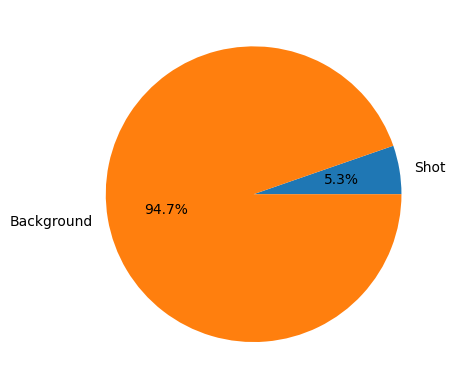

In [ ]:
labels = 'Shot', 'Background'
shot_percent = shot_cant / (shot_cant + back_cant)
back_percent = back_cant / (shot_cant + back_cant)

fig, ax = plt.subplots()
_, _, _ = ax.pie((shot_percent, back_percent), labels=labels, autopct='%1.1f%%')

## Choose random audio

In [ ]:
shot_name = DATASET['audio_name'][DATASET['labels'] == 1].sample().values[0]
back_name = DATASET['audio_name'][DATASET['labels'] == 0].sample().values[0]

shot_sound, shot_sr = librosa.load(shot_name, sr=SAMPLE_RATE)
# shot_sound = librosa.resample(shot_sound, orig_sr=shot_sr, target_sr=SAMPLE_RATE)
shot_sound = filters(shot_sound, shot_sr)

back_sound, back_sr = librosa.load(back_name, sr=SAMPLE_RATE)
# back_sound = librosa.resample(back_sound, orig_sr=back_sr, target_sr=SAMPLE_RATE)
back_sound = filters(back_sound, back_sr)

## Basic information regarding audios

In [ ]:
shot_sound.shape

(64000,)

In [ ]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / back_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000063 seconds


In [ ]:
back_sr

16000

In [ ]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

64000

In [ ]:
# duration of the audio signal in seconds
duration = duration_sample * len(back_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [ ]:
ipd.Audio(shot_sound, rate=SAMPLE_RATE)

In [ ]:
ipd.Audio(back_sound, rate=SAMPLE_RATE)

## Visualize graphs

### Envelope

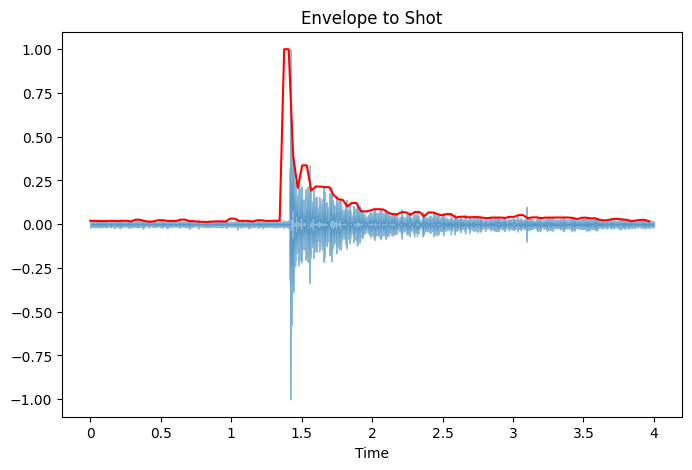

In [ ]:
# SHOT

plot_waveform(shot_sound, SAMPLE_RATE, 'Shot')

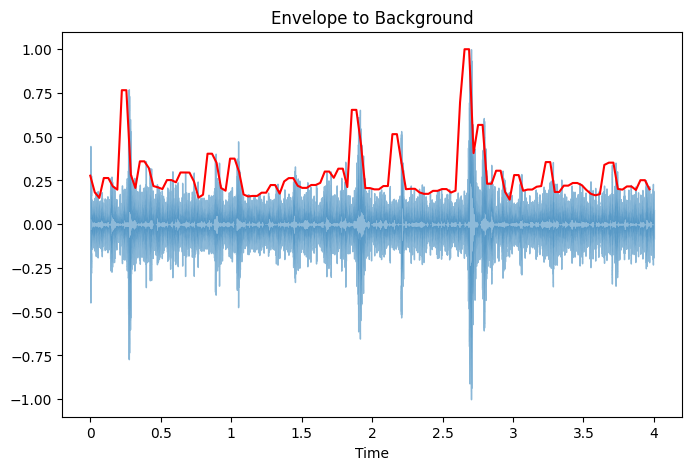

In [ ]:
# BACKGROUND

plot_waveform(back_sound, SAMPLE_RATE, 'Background')

### Frequency domain

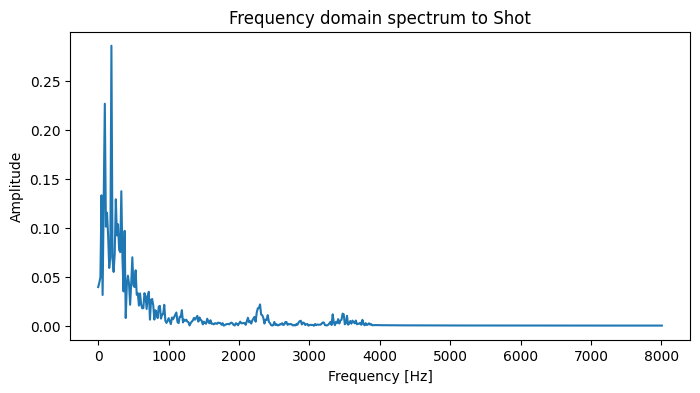

In [ ]:
# SHOT
plot_fft(shot_sound, SAMPLE_RATE, audio_type='Shot')

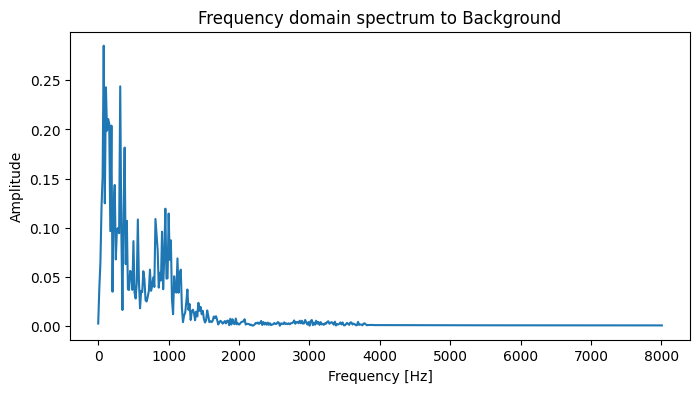

In [ ]:
# BACKGROUND
plot_fft(back_sound, SAMPLE_RATE, audio_type='Background')

### Spectrogram

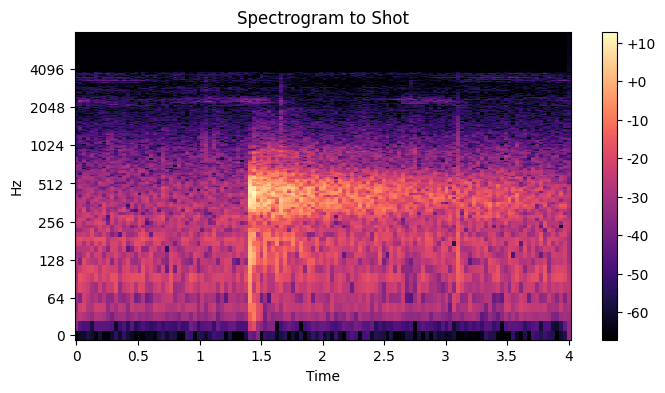

In [ ]:
# SHOT
plot_spectrogram(shot_sound, SAMPLE_RATE, y_axis='log', audio_type='Shot')

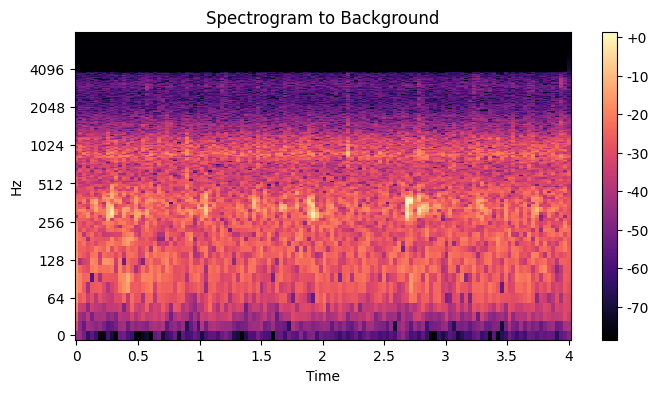

In [ ]:
# BACKGROUND
plot_spectrogram(back_sound, SAMPLE_RATE, y_axis='log', audio_type='Background')

### Mel spectrogram

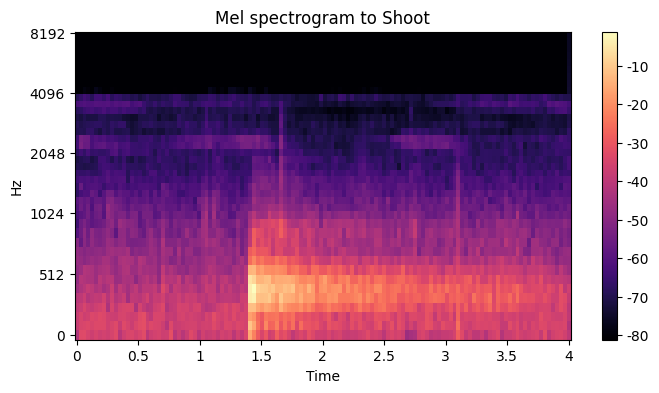

In [ ]:
# SHOT
plot_mel_spectrogram(shot_sound, SAMPLE_RATE, audio_type='Shoot')

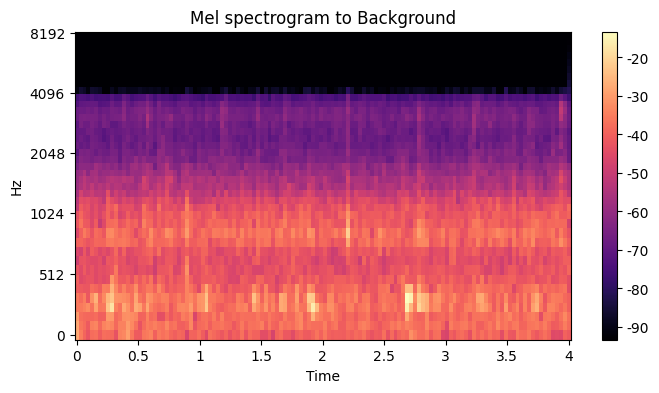

In [ ]:
# BACKGROUND
plot_mel_spectrogram(back_sound, SAMPLE_RATE, audio_type='Background')

### Mel-Frequency Cepstral Coefficients

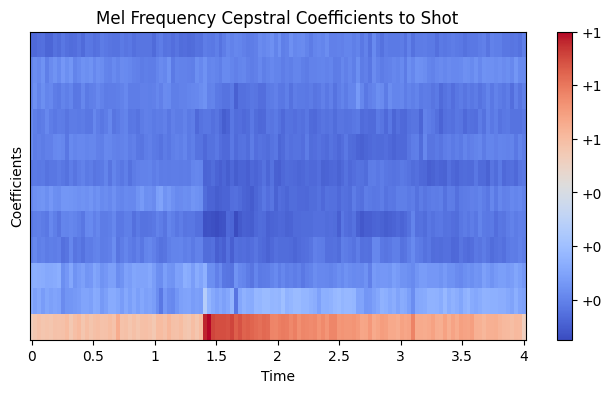

In [ ]:
# SHOT
mfcc = extract_mfccs(shot_sound, SAMPLE_RATE)

plot_mfcc(mfcc, SAMPLE_RATE, 'Shot')

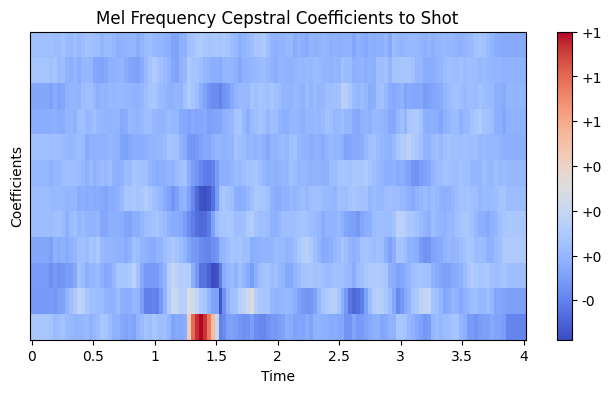

In [ ]:
delta = extract_delta(mfcc, 1)

plot_mfcc(delta, SAMPLE_RATE, 'Shot')

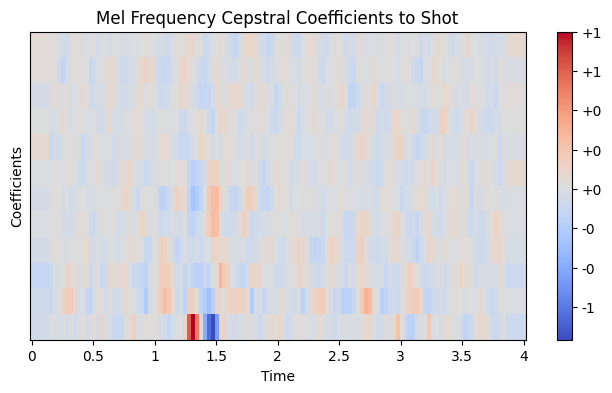

In [ ]:
delta = extract_delta(mfcc, 2)

plot_mfcc(delta, SAMPLE_RATE, 'Shot')

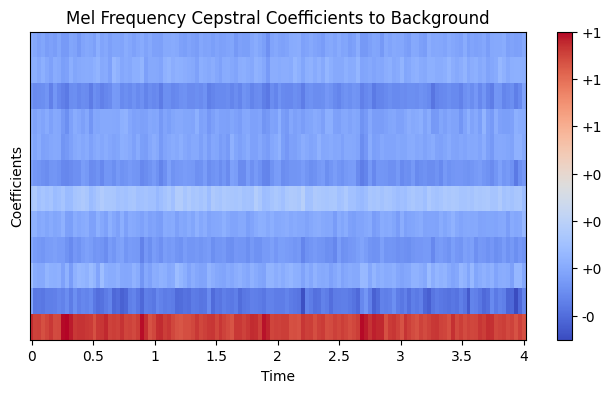

In [ ]:
# BACKGROUND
mfcc = extract_mfccs(back_sound, SAMPLE_RATE)

plot_mfcc(mfcc, SAMPLE_RATE, 'Background')

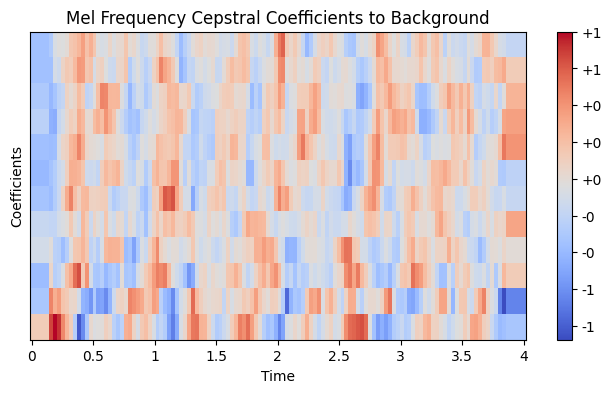

In [ ]:
delta = extract_delta(mfcc, 1)

plot_mfcc(delta, SAMPLE_RATE, 'Background')

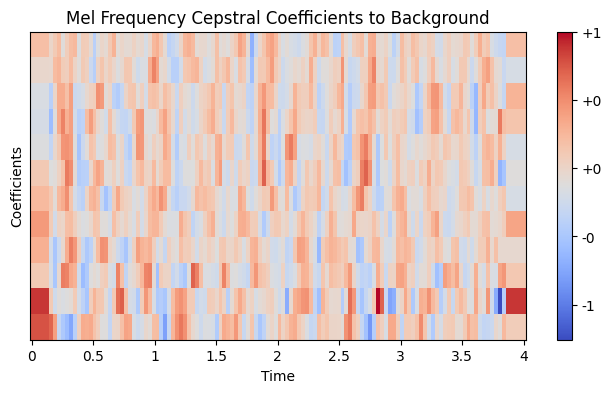

In [ ]:
delta = extract_delta(mfcc, 2)

plot_mfcc(delta, SAMPLE_RATE, 'Background')

### Spectral Centroids

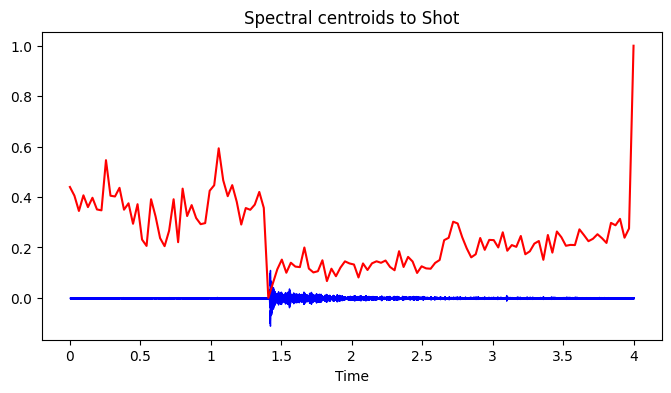

In [ ]:
# SHOT
plot_spectral_centroid(shot_sound, shot_sr, 'Shot')

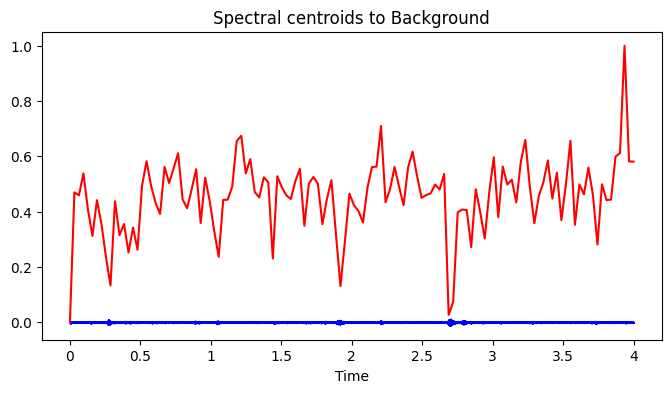

In [ ]:
# BACKGROUND
plot_spectral_centroid(back_sound, back_sr, 'Background')

# Prepare Data to Train and Val

### Train

In [ ]:
shot_dir = DATASET['audio_name'][DATASET['labels'] == 1].values
shot_labels = DATASET['labels'][DATASET['labels'] == 1].values

back_dir = DATASET['audio_name'][DATASET['labels'] == 0].values[:600]
back_label = DATASET['labels'][DATASET['labels'] == 0].values[:600]

shot_signals = [filters(librosa.load(shot_name, sr=SAMPLE_RATE)[0], SAMPLE_RATE) for shot_name in shot_dir]
back_signals = [filters(librosa.load(back_name, sr=SAMPLE_RATE)[0], SAMPLE_RATE) for back_name in back_dir]

### Data Augmentation

In [ ]:
# from audiomentations import Compose, LowPassFilter, Shift, TimeMask

In [ ]:
# # Augmentations
# augment = Compose([
#     LowPassFilter(min_cutoff_freq=0, max_cutoff_freq=2048.0, p=1.0),
#     Shift(min_shift=-1.5, max_shift=1.5, shift_unit='seconds', p=1.0),
#     TimeMask(min_band_part=0.01, max_band_part=0.02, fade=True, p=0.3)
# ])

# augmented_sounds_1 = [augment(shot, SAMPLE_RATE) for shot in shot_signals]
# augmented_sounds_2 = [augment(shot, SAMPLE_RATE) for shot in shot_signals]

In [ ]:
# shot_signals = np.concatenate((shot_signals, augmented_sounds_1, augmented_sounds_2))
# shot_labels = np.zeros(shot_signals.shape[0])

In [ ]:
# Only for CNN or LSTM
shot_mfcc = np.array([extract_mfccs(shot, SAMPLE_RATE).T for shot in shot_signals])

back_mfcc = np.array([extract_mfccs(back, SAMPLE_RATE).T for back in back_signals])

In [ ]:
X = np.concatenate((shot_mfcc, back_mfcc))
y = np.concatenate((shot_labels, back_label))

In [ ]:
# create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
X_train = np.concatenate((X_train, X_test))
y_train = np.concatenate((y_train, y_test))

X_train = X_train[..., np.newaxis] # ONLY CNN

### Val

In [ ]:
shot_dir = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 1].values
shot_label = VAL_DATASET['labels'][VAL_DATASET['labels'] == 1].values

back_dir = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 0].values[:200]
back_label = VAL_DATASET['labels'][VAL_DATASET['labels'] == 0].values[:200]

shot_signals =[filters(librosa.load(shot_name, sr=SAMPLE_RATE)[0], SAMPLE_RATE) for shot_name in shot_dir]
back_signals = [filters(librosa.load(back_name, sr=SAMPLE_RATE)[0], SAMPLE_RATE) for back_name in back_dir]

In [ ]:
# Only for CNN or LSTM
shot_mfcc = np.array([extract_mfccs(shot, SAMPLE_RATE).T for shot in shot_signals])
back_mfcc = np.array([extract_mfccs(back, SAMPLE_RATE).T for back in back_signals])

In [ ]:
X = np.concatenate((shot_mfcc, back_mfcc))
y = np.concatenate((shot_label, back_label))

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### Info

In [ ]:
print(f"Train shape: {X_train.shape}")

Train shape: (1197, 126, 12, 1)


In [ ]:
print(f"1. Validation shape: {X_val.shape}")

1. Validation shape: (280, 126, 12, 1)


In [ ]:
print(f"Test shape: {X_test.shape}")

Test shape: (70, 126, 12, 1)


# Implementing a Neural Network

## Plot History

In [ ]:
def plot_history(history):
    """
        Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

## Prediction function

In [ ]:
def predict(model, X, y):
  """Predict a single sample using the trained model

  :param model: Trained classifier
  :param X: Input data
  :param y (int): Target
  """

  # add a dimension to input data for sample - model.predict() expects a 4d array in this case
  X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

  # perform prediction
  prediction = model.predict(X)
  prediction = round(prediction[0][0])

  print("Target: {}, Predicted label: {}".format(y, prediction))

## Only dense

In [ ]:
model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),

        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),

        # 3rd hidden layer
        keras.layers.Dense(64, activation="relu"),

        # output layer
        keras.layers.Dense(2, activation="softmax")
        ])

## Convolutional Network

In [ ]:
def build_model(input_shape):

  """Generates CNN model

  :param input_shape (tuple): Shape of input set
  :return model: CNN model
  """

  # create model
  model = keras.Sequential()

  # 1st conv layer
  model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # 2nd conv layer
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # 3rd conv layer
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # flatten output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.Dropout(0.5))

  # output layer
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  return model


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

## LSTM

In [ ]:
def build_model(input_shape):
    """Generates improved RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: Improved RNN-LSTM model
    """

    # Build network topology
    model = keras.Sequential()

    # LSTM layers with Batch Normalization
    model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.LSTM(64))
    model.add(keras.layers.BatchNormalization())

    # Dense layers with Dropout and Batch Normalization
    model.add(keras.layers.Dense(64, activation='tanh'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [ ]:
conv_input = (X_train.shape[1], X_train.shape[2], 1)
lstm_input = (12, 10)
model = build_model(conv_input, lstm_input)

## Compile network

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 10, 128)      1280      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 5, 128)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 62, 5, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 3, 64)         73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 2, 64)         0         
 g2D)                                                            
                                                      

In [ ]:
# train model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = False)

checkpoint_filepath = '/content/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                monitor="val_loss",
                                                mode="min",
                                                save_best_only=True,
                                                verbose=1)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.2,
                    batch_size=32,
                    epochs=100,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 1.1323 - accuracy: 0.7210
Epoch 1: val_loss improved from inf to 1.65039, saving model to /content/checkpoint
38/38 [==============================] - 10s 267ms/step - loss: 1.1323 - accuracy: 0.7210 - val_loss: 1.6504 - val_accuracy: 0.4179
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.0936 - accuracy: 0.7460
Epoch 2: val_loss did not improve from 1.65039
38/38 [==============================] - 6s 158ms/step - loss: 1.0936 - accuracy: 0.7460 - val_loss: 1.7075 - val_accuracy: 0.4179
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 1.0861 - accuracy: 0.7277
Epoch 3: val_loss did not improve from 1.65039
38/38 [==============================] - 8s 196ms/step - loss: 1.0861 - accuracy: 0.7277 - val_loss: 1.6971 - val_accuracy: 0.4179
Epoch 4/100
38/38 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.7335
Epoch 4: val_loss did not improve from 1.65039
3

## Evaluate model on val set

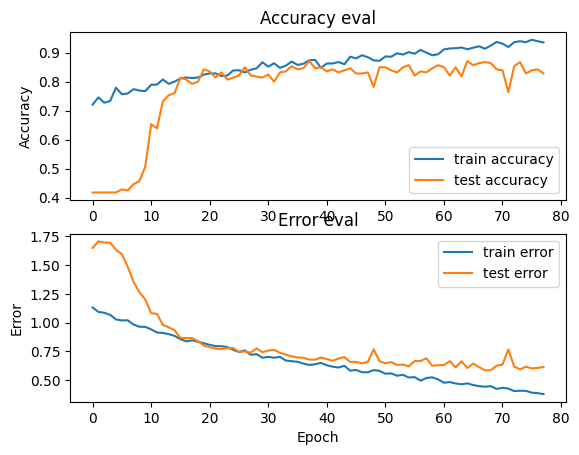

In [ ]:
plot_history(history)

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.7535 - accuracy: 0.7000 - 84ms/epoch - 28ms/step

Test accuracy: 0.699999988079071


In [ ]:
shoot_index = [i for i, e in enumerate(y_test) if e == 1]

X_shoot = X_test[shoot_index]
y_shoot = y_test[shoot_index]

In [ ]:
# evaluate model on test set only shoots
val_loss, val_acc = model.evaluate(X_shoot, y_shoot, verbose=2)
print('\nTest accuracy:', val_acc)

2/2 - 0s - loss: 0.7618 - accuracy: 0.6667 - 55ms/epoch - 28ms/step

Test accuracy: 0.6666666865348816


In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[23]
y_to_predict = y_test[23]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 96ms/step
Target: 1, Predicted label: 1


In [ ]:
# Confusion matrix
# from sklearn.metrics import confusion_matrix

prediction = model.predict(X_test)
prediction = np.array([round(pred[0]) for pred in prediction])

tf.math.confusion_matrix(labels=y_test, predictions=prediction, num_classes=2)

3/3 [==============================] - 0s 52ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[43,  4],
       [ 6, 17]], dtype=int32)>

## Save model

In [ ]:
model.save("CNN_MODEL_16k_1024.keras")

## Load model

In [ ]:
loaded_model = keras.models.load_model("CNN_MODEL_16k_1024.keras")

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
shoot_index = [i for i, e in enumerate(y_test) if e == 1]

X_shoot = X_test[shoot_index]
y_shoot = y_test[shoot_index]

In [ ]:
# evaluate model on test set only shoots
val_loss, val_acc = model.evaluate(X_shoot, y_shoot, verbose=2)
print('\nTest accuracy:', val_acc)

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[23]
y_to_predict = y_test[23]

# predict sample
predict(model, X_to_predict, y_to_predict)

In [ ]:
# Confusion matrix

prediction = model.predict(X_test)
prediction = np.array([round(pred[0]) for pred in prediction])

tf.math.confusion_matrix(labels=y_test, predictions=prediction, num_classes=2)

# Load complete sound to infer

In [ ]:
AUDIO_PATH = '/content/shots/50.wav'

SEGMENT_DURATION = 4 # measured in second

In [ ]:
def extract_segments(signal, samples_per_segment, num_segments):

  segments = []

  for s in range(num_segments):
    start = s * samples_per_segment
    finish = start + samples_per_segment

    segment = signal[start:finish]

    segments.append(segment)

  return np.array(segments)

In [ ]:
umbral = 0.9

def infer():

  mfcc = []

  # load audio
  signal, sr = librosa.load(AUDIO_PATH, sr=SAMPLE_RATE)

  signal = filters(signal, SAMPLE_RATE)

  print(f"Frecuencia de muestreo: {sr} Hz")

  # extract audio duration
  duration = len(signal)//sr

  print(f"Duracion {duration} seconds")

  # resize audio
  signal = signal[:duration*sr]

  # get number of SEGMENT_DURATION second segments
  num_segments = duration//SEGMENT_DURATION

  print(f"Numero de segmentos: {num_segments}")

  # get samples per segments
  samples_per_segments = SEGMENT_DURATION * sr

  print(f"Muestras por cada segmento: {samples_per_segments}\n")

  # extract SEGMENT_DURATION segments
  segments = extract_segments(signal, samples_per_segments, num_segments)

  # extract mfcc for each segment
  mfcc = np.array([extract_mfccs(seg, sr).T for seg in segments])

  for i in range(len(mfcc)):
    seg = mfcc[i]
    seg = seg[np.newaxis, ..., np.newaxis]

    pred = model.predict(seg)[0][0]

    print(f"Prediction: {pred}")

    if pred >= umbral:
      inicio_segundos = SEGMENT_DURATION * i
      fin_segundos = inicio_segundos + SEGMENT_DURATION

      # Convertir a minutos si supera los 60 segundos
      if fin_segundos > 60:
          inicio_minutos = inicio_segundos // 60
          inicio_segundos = inicio_segundos % 60
          fin_minutos = fin_segundos // 60
          fin_segundos = fin_segundos % 60

          print("Shot between: {}:{} and {}:{} minutes".format(inicio_minutos, inicio_segundos, fin_minutos, fin_segundos))
      else:
          print("Shot between: {} and {} seconds".format(inicio_segundos, fin_segundos))

In [ ]:
infer()

Frecuencia de muestreo: 16000 Hz
Duracion 4 seconds
Numero de segmentos: 1
Muestras por cada segmento: 64000

1/1 [==============================] - 0s 32ms/step
Prediction: 0.9017450213432312
Shot between: 0 and 4 seconds
